In [1]:
# hyperparameters
datapath = './adult.csv'
learning_rate = 5e-4
batch_size = 16
max_length = 100
epochs = 1

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import transformers
from torch import nn
import torch
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
from matplotlib import pyplot as plt
from tqdm import tqdm 

/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = transformers.AutoModelForCausalLM.from_pretrained('distilgpt2')
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token
special_tokens_dict = {"bos_token": "<BOS>", 'eos_token': '<EOS>'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

def row_to_col_sentences(row):
    return [str(col).strip() + " is " + str(val).strip() + '.<EOS>' for col, val in zip(row.index, row.values)]

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=100):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = 100

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = row_to_col_sentences(data.iloc[idx])
        
        text = tokenizer.bos_token + ''.join(text)
        tokenized_text = self.tokenizer(text, truncation=True, max_length=self.max_length, padding='max_length', return_tensors='pt')
        return tokenized_text.input_ids.squeeze(), tokenized_text.attention_mask.squeeze()
            
            
# Load the dataset
data = pd.read_csv(datapath)
text_data = data.apply(row_to_col_sentences, axis=1).tolist()
dataset = TextDataset(text_data, tokenizer, max_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


100%|██████████| 3053/3053 [12:09<00:00,  4.19it/s]


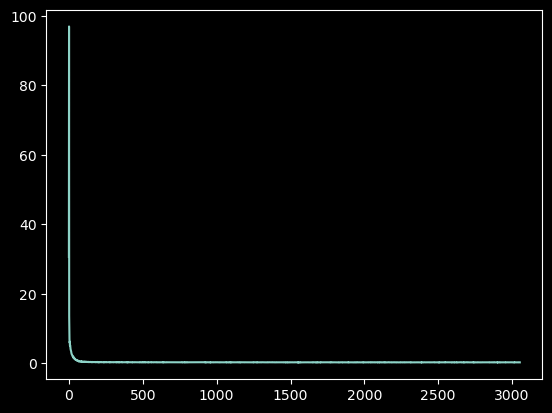

In [4]:
model.train()
# Move the model to the device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.resize_token_embeddings(len(tokenizer))


optimizer = AdamW(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(epochs): 
    for batch in tqdm(dataloader):
        # print(batch)
        input_ids, attention_mask = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        
plt.plot(losses)

In [5]:
# tokenizer.batch_decode(model.generate(max_length=max_length))[0] # search
tokenizer.batch_decode(model.generate(do_sample=True, num_beams=1, max_length=max_length))[0] #sample

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


'<|endoftext|>age is 25.<EOS>workclass is Private.<EOS>fnlwgt is 224541.<EOS>education is Bachelors.<EOS>education-num is 13.<EOS>marital-status is Never-married.<EOS>occupation is Tech-support.<EOS>relationship is Not-in-family.<EOS>race is White.<EOS>sex is Female.<EOS>capital-gain is 0.<EOS>capital-loss is 0.<EOS>hours-per-week is 40.<EOS>native-country'